In [1]:
# default_exp models.onnbeats.nbeats

In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [104]:
#export
import os
import time
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import copy

import torch as t
from torch import optim
import torch.nn.functional as F
from pathlib import Path
from functools import partial

from nixtla.models.onnbeats.nbeats_model import NBeats, NBeatsBlock, IdentityBasis
from nixtla.models.onnbeats.nbeats_model import TrendBasis, SeasonalityBasis, ExogenousFutureBasis, ExogenousBasisInterpretable
from nixtla.losses.pytorch import MAPELoss, MASELoss, SMAPELoss, MSELoss, MAELoss, RMSELoss
from nixtla.losses.numpy import mae, mse, mape, smape, rmse, accuracy_logits, metric_protections

# export
def accuracy_logits(y: np.ndarray, y_hat: np.ndarray, weights=None, thr=0.5) -> np.ndarray:
    """Calculates the Accuracy.

    Parameters
    ----------
    y: numpy array
      actual test values
    y_hat: numpy array of len h (forecasting horizon)
      predicted values
    weights: numpy array
      weights for weigted average
    Return
    ------
    return accuracy
    """
    metric_protections(y, y_hat, weights)

    y_hat = ((1/(1 + np.exp(-y_hat))) > thr) * 1
    correct = (y==y_hat)[~np.isnan(y)]
    if weights is not None:
      accuracy = np.average(correct, weights=weights[~np.isnan(y)]) * 100
    else:
      accuracy = np.nanmean(correct) * 100
    return (1-accuracy)

# export
def true_positive_rate(y: np.ndarray, y_hat: np.ndarray, weights=None, thr=0.5) -> np.ndarray:
    """Calculates the Accuracy.

    Parameters
    ----------
    y: numpy array
      actual test values
    y_hat: numpy array of len h (forecasting horizon)
      predicted values
    weights: numpy array
      weights for weigted average
    Return
    ------
    return accuracy
    """
    metric_protections(y, y_hat, weights)

    y_hat = ((1/(1 + np.exp(-y_hat))) > thr) * 1
    tpr = true_positive = np.sum(((y > 0) * (y_hat > 0))) / (np.sum((y>0)))
    return tpr


In [82]:
#export
class Nbeats(object):
    """
    Future documentation
    """
    SEASONALITY_BLOCK = 'seasonality'
    TREND_BLOCK = 'trend'
    IDENTITY_BLOCK = 'identity'

    def __init__(self,
                 input_size_multiplier,
                 output_size,
                 shared_weights,
                 stack_types,
                 n_blocks,
                 n_layers,
                 n_hidden,
                 n_harmonics,
                 n_polynomials,
                 exogenous_n_channels,
                 f_cols,
                 theta_with_exogenous,
                 batch_normalization,
                 dropout_prob,
                 x_s_n_hidden,
                 learning_rate,
                 lr_decay,
                 n_lr_decay_steps,
                 l1_lambda_x,
                 weight_decay,
                 n_iterations,
                 early_stopping,
                 loss,
                 val_loss,
                 frequency,
                 seasonality,
                 random_seed,
                 device=None):
        super(Nbeats, self).__init__()

        self.input_size = int(input_size_multiplier*output_size)
        self.output_size = output_size
        self.shared_weights = shared_weights
        self.stack_types = stack_types
        self.n_blocks = n_blocks
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_harmonics = n_harmonics
        self.n_polynomials = n_polynomials
        self.exogenous_n_channels = exogenous_n_channels
        self.f_cols = f_cols
        self.theta_with_exogenous = theta_with_exogenous
        self.batch_normalization = batch_normalization
        self.dropout_prob = dropout_prob
        self.x_s_n_hidden = x_s_n_hidden
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.n_lr_decay_steps = n_lr_decay_steps
        self.l1_lambda_x = l1_lambda_x
        self.weight_decay = weight_decay
        self.n_iterations = n_iterations
        self.early_stopping = early_stopping
        self.loss = loss
        self.val_loss = val_loss
        self.frequency = frequency
        self.seasonality = seasonality
        self.random_seed = random_seed
        if device is None:
            device = 'cuda' if t.cuda.is_available() else 'cpu'
        self.device = device

        self._is_instantiated = False

    def create_stack(self):
        # Declare parameter dimensions
        if self.theta_with_exogenous:
            x_t_n_inputs = self.input_size + self.n_x_t
        else:
            x_t_n_inputs = self.input_size # y_lags
        
        #------------------------ Model Definition ------------------------#
        block_list = []
        self.blocks_regularizer = []
        for i in range(len(self.stack_types)):
            #print(f'| --  Stack {self.stack_types[i]} (#{i})')
            for block_id in range(self.n_blocks[i]):
                # Batch norm only on first block
                if (len(block_list)==0) and (self.batch_normalization):
                    batch_normalization_block = True
                else:
                    batch_normalization_block = False

                # Dummy of regularizer in block. Override with 1 if exogenous_block
                #self.blocks_regularizer += [0]

                # Shared weights
                if self.shared_weights and block_id>0:
                    nbeats_block = block_list[-1]

                else:
                    if self.stack_types[i] == 'seasonality':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=4 * int(
                                                        np.ceil(self.n_harmonics / 2 * self.output_size) - (self.n_harmonics - 1)),
                                                   basis=SeasonalityBasis(harmonics=self.n_harmonics,
                                                                                backcast_size=self.input_size,
                                                                                forecast_size=self.output_size),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   theta_with_exogenous=self.theta_with_exogenous,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob)
                    elif self.stack_types[i] == 'trend':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2 * (self.n_polynomials + 1),
                                                   basis=TrendBasis(degree_of_polynomial=self.n_polynomials,
                                                                            backcast_size=self.input_size,
                                                                            forecast_size=self.output_size),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   theta_with_exogenous=self.theta_with_exogenous,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob)
                    elif self.stack_types[i] == 'identity':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=self.input_size + self.output_size,
                                                   basis=IdentityBasis(backcast_size=self.input_size,
                                                                       forecast_size=self.output_size),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   theta_with_exogenous=self.theta_with_exogenous,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob)
                    elif self.stack_types[i] == 'exogenous':
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2*self.n_x_t,
                                                   basis=ExogenousBasisInterpretable(),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   theta_with_exogenous=self.theta_with_exogenous,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob)
                    elif self.stack_types[i] == 'exogenous_g_a':
                        assert len(self.f_cols)>0, 'If ExogenousFutureBasis, provide x_f_cols hyperparameter'
                        nbeats_block = NBeatsBlock(x_t_n_inputs = x_t_n_inputs,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2*(self.exogenous_n_channels),
                                                   basis=ExogenousFutureBasis(out_features=self.exogenous_n_channels,
                                                                              f_idxs=self.f_idxs),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   theta_with_exogenous=self.theta_with_exogenous,
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob)
                #        self.blocks_regularizer[-1] = 1
                #print(f'     | -- {nbeats_block}')
                block_list.append(nbeats_block)
        return block_list

    def __loss_fn(self, loss_name: str):
        def loss(x, freq, forecast, target, mask):
            if loss_name == 'MAPE':
                return MAPELoss(y=target, y_hat=forecast, mask=mask) + self.l1_regularization()
            elif loss_name == 'MASE':
                return MASELoss(y=target, y_hat=forecast, y_insample=x, seasonality=freq, mask=mask) + self.l1_regularization()
            elif loss_name == 'SMAPE':
                return SMAPELoss(y=target, y_hat=forecast, mask=mask) + self.l1_regularization()
            elif loss_name == 'MSE':
                return MSELoss(y=target, y_hat=forecast, mask=mask) + self.l1_regularization()
            elif loss_name == 'RMSE':
                return RMSELoss(y=target, y_hat=forecast, mask=mask) + self.l1_regularization()
            elif loss_name == 'MAE':
                return MAELoss(y=target, y_hat=forecast, mask=mask) + self.l1_regularization()
            elif loss_name == 'BCE':
                return F.binary_cross_entropy_with_logits(input=forecast, target=target, weight=mask)
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss

    def __val_loss_fn(self, loss_name: str):
        #TODO: mase not implemented
        def loss(forecast, target, weights):
            if loss_name == 'MAPE':
                return mape(y=target, y_hat=forecast, weights=weights) #TODO: faltan weights
            elif loss_name == 'SMAPE':
                return smape(y=target, y_hat=forecast, weights=weights) #TODO: faltan weights
            elif loss_name == 'MSE':
                return mse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'RMSE':
                return rmse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MAE':
                return mae(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'Accuracy':
                return accuracy_logits(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'TPR':
                return true_positive_rate(y=target, y_hat=forecast, weights=weights)
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss

    def l1_regularization(self):
        # l1_loss = 0
        # for i, indicator in enumerate(self.blocks_regularizer):
        #     if indicator:
        #         l1_loss +=  self.l1_lambda*t.sum(t.abs(self.model.blocks[i].basis.weight))
        # return l1_loss
        return self.l1_lambda_x * t.sum(t.abs(self.model.l1_weight))

    def to_tensor(self, x: np.ndarray) -> t.Tensor:
        tensor = t.as_tensor(x, dtype=t.float32).to(self.device)
        return tensor

    def evaluate_performance(self, ts_loader, validation_loss_fn):
        #TODO: mas opciones que mae
        self.model.eval()

        losses = []
        with t.no_grad():
            for batch in iter(ts_loader):
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                insample_mask  = self.to_tensor(batch['insample_mask'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                outsample_y    = self.to_tensor(batch['outsample_y'])
                outsample_mask = self.to_tensor(batch['outsample_mask'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                forecast = self.model(insample_y=insample_y, insample_x_t=insample_x,
                                    insample_mask=insample_mask, outsample_x_t=outsample_x, x_s=s_matrix)
                batch_loss = validation_loss_fn(target=outsample_y.cpu().data.numpy(),
                                                forecast=forecast.cpu().data.numpy(),
                                                weights=outsample_mask.cpu().data.numpy())
                losses.append(batch_loss)
        loss = np.mean(losses)
        self.model.train()
        return loss

    def fit(self, train_ts_loader, val_ts_loader=None, n_iterations=None, verbose=True, eval_steps=1):
        # Asserts
        assert train_ts_loader.t_cols[0] == 'y', f'First variable must be y not {train_ts_loader.t_cols[0]}'
        assert train_ts_loader.t_cols[1] == 'ejecutado', f'First exogenous variable must be ejecutado not {train_ts_loader.t_cols[1]}'
        assert (self.input_size)==train_ts_loader.input_size, \
            f'model input_size {self.input_size} data input_size {train_ts_loader.input_size}'        

        # Random Seeds (model initialization)
        t.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)
        random.seed(self.random_seed) #TODO: interaccion rara con window_sampling de validacion

        # Attributes of ts_dataset
        self.n_x_t, self.n_x_s = train_ts_loader.get_n_variables()
        self.t_cols = train_ts_loader.t_cols
        self.f_idxs = train_ts_loader.ts_dataset.get_f_idxs(self.f_cols)

        # Instantiate model
        if not self._is_instantiated:
            block_list = self.create_stack()
            self.model = NBeats(blocks=t.nn.ModuleList(block_list), in_features=self.n_x_t).to(self.device)
            self._is_instantiated = True

        # Overwrite n_iterations and train datasets
        if n_iterations is None:
            n_iterations = self.n_iterations

        lr_decay_steps = n_iterations // self.n_lr_decay_steps
        if lr_decay_steps == 0:
            lr_decay_steps = 1

        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_steps, gamma=self.lr_decay)

        training_loss_fn = self.__loss_fn(self.loss)
        validation_loss_fn = self.__val_loss_fn(self.val_loss) #Uses numpy losses

        if verbose and (n_iterations > 0):
            print('='*30+' Start fitting '+'='*30)
            print(f'Number of exogenous variables: {self.n_x_t}')
            print(f'Number of static variables: {self.n_x_s} , with dim_hidden: {self.x_s_n_hidden}')
            print(f'Number of iterations: {n_iterations}')
            print(f'Number of blocks: {len(self.model.blocks)}')

        #self.loss_dict = {} # Restart self.loss_dict
        start = time.time()
        self.trajectories = {'iteration':[],'train_loss':[], 'val_loss':[]}
        self.final_insample_loss = None
        self.final_outsample_loss = None

        # Training Loop
        best_val_loss = np.inf
        early_stopping_counter = 0
        best_state_dict = copy.deepcopy(self.model.state_dict())
        break_flag = False
        iteration = 0
        epoch = 0
        while (iteration < n_iterations) and (not break_flag):
            epoch +=1
            for batch in iter(train_ts_loader):
                iteration += 1
                if (iteration > n_iterations) or (break_flag):
                    continue
                self.model.train()

                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                insample_mask  = self.to_tensor(batch['insample_mask'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                outsample_y    = self.to_tensor(batch['outsample_y'])
                outsample_mask = self.to_tensor(batch['outsample_mask'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                optimizer.zero_grad()
                forecast = self.model(insample_y=insample_y, insample_x_t=insample_x,
                                    insample_mask=insample_mask, outsample_x_t=outsample_x, x_s=s_matrix)

                training_loss = training_loss_fn(x=insample_y, freq=self.seasonality, forecast=forecast,
                                                target=outsample_y, mask=outsample_mask)

                if np.isnan(float(training_loss)):
                    break

                training_loss.backward()
                t.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                lr_scheduler.step()
                if (iteration % eval_steps == 0):
                    display_string = 'Iteration: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                                    time.time()-start,
                                                                                    self.loss,
                                                                                    training_loss.cpu().data.numpy())
                    self.trajectories['iteration'].append(iteration)
                    self.trajectories['train_loss'].append(training_loss.cpu().data.numpy())

                    if val_ts_loader is not None:
                        loss = self.evaluate_performance(val_ts_loader, validation_loss_fn=validation_loss_fn)
                        display_string += ", Outsample {}: {:.5f}".format(self.val_loss, loss)
                        self.trajectories['val_loss'].append(loss)

                        if self.early_stopping:
                            if loss < best_val_loss:
                                # Save current model if improves outsample loss
                                best_state_dict = copy.deepcopy(self.model.state_dict())
                                best_insample_loss = training_loss.cpu().data.numpy()
                                early_stopping_counter = 0
                                best_val_loss = loss
                            else:
                                early_stopping_counter += 1
                            if early_stopping_counter >= self.early_stopping:
                                break_flag = True

                    print(display_string)

                    self.model.train()

                if break_flag:
                    print(10*'-',' Stopped training by early stopping', 10*'-')
                    self.model.load_state_dict(best_state_dict)
                    break

        #End of fitting
        if n_iterations >0:
            self.final_insample_loss = training_loss.cpu().data.numpy() if not break_flag else best_insample_loss #This is batch!
            string = 'Iteration: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                            time.time()-start,
                                                                            self.loss,
                                                                            self.final_insample_loss)
            if val_ts_loader is not None:
                self.final_outsample_loss = self.evaluate_performance(val_ts_loader, validation_loss_fn=validation_loss_fn)
                string += ", Outsample {}: {:.5f}".format(self.val_loss, self.final_outsample_loss)
            print(string)
            print('='*30+'End fitting '+'='*30)

    def predict(self, ts_loader, X_test=None, eval_mode=False):
        self.model.eval()
        assert not ts_loader.shuffle, 'ts_loader must have shuffle as False.'

        forecasts = []
        outsample_ys = []
        outsample_masks = []
        with t.no_grad():
            for batch in iter(ts_loader):
                insample_y     = self.to_tensor(batch['insample_y'])
                insample_x     = self.to_tensor(batch['insample_x'])
                insample_mask  = self.to_tensor(batch['insample_mask'])
                outsample_x    = self.to_tensor(batch['outsample_x'])
                s_matrix       = self.to_tensor(batch['s_matrix'])

                forecast = self.model(insample_y=insample_y, insample_x_t=insample_x,
                                      insample_mask=insample_mask, outsample_x_t=outsample_x, x_s=s_matrix)
                forecasts.append(forecast.cpu().data.numpy())
                outsample_ys.append(batch['outsample_y'])
                outsample_masks.append(batch['outsample_mask'])
        forecasts = np.vstack(forecasts)
        outsample_ys = np.vstack(outsample_ys)
        outsample_masks = np.vstack(outsample_masks)

        self.model.train()
        if eval_mode:
            return outsample_ys, forecasts, outsample_masks

        # Pandas wrangling
        frequency = ts_loader.get_frequency()
        unique_ids = ts_loader.get_meta_data_col('unique_id')
        last_ds = ts_loader.get_meta_data_col('last_ds') #TODO: ajustar of offset

        # Predictions for panel
        Y_hat_panel = pd.DataFrame(columns=['unique_id', 'ds'])
        for i, unique_id in enumerate(unique_ids):
            Y_hat_id = pd.DataFrame([unique_id]*self.output_size, columns=["unique_id"])
            ds = pd.date_range(start=last_ds[i], periods=self.output_size+1, freq=frequency)
            Y_hat_id["ds"] = ds[1:]
            Y_hat_panel = Y_hat_panel.append(Y_hat_id, sort=False).reset_index(drop=True)

        Y_hat_panel['y_hat'] = forecasts.flatten()

        if X_test is not None:
            Y_hat_panel = X_test.merge(Y_hat_panel, on=['unique_id', 'ds'], how='left')
        
        return Y_hat_panel


    def save(self, model_dir, model_id):

        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        print('Saving model to:\n {}'.format(model_file)+'\n')
        t.save({'model_state_dict': self.model.state_dict()}, model_file)

    def load(self, model_dir, model_id):

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        path = Path(model_file)

        assert path.is_file(), 'No model_*.model file found in this path!'

        print('Loading model from:\n {}'.format(model_file)+'\n')

        checkpoint = t.load(model_file, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)


In [72]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import torch as t
import copy
from fastcore.foundation import patch
from nixtla.data.ontsdataset import TimeSeriesDataset
from nixtla.data.ontsloader_fast import TimeSeriesLoader as TimeSeriesLoaderFast
# from nixtla.data.tsloader_pinche import TimeSeriesLoader as TimeSeriesLoaderPinche
# from nixtla.data.tsloader_general import TimeSeriesLoader as TimeSeriesLoaderGeneral

#from nixtla.models.nbeats.onnbeats import Nbeats
from nixtla.data.datasets.on import load_on_data
np.random.seed(1)
t.manual_seed(1)

def get_top6(df, variable):
    if 'top' in df.columns:
        del df['top']

    assert (df.shape[0] % 96 == 0), \
        f'Data does not have complete days extra {df.shape[0] % 96} observations'
    
    new_df = df.copy()

    new_df['ds_day'] = new_df['ds'].dt.date
    n_days = len(new_df.ds_day.unique())

    # Create top_df
    # Y_new_df.sort_values(by=[ 'unique_id', 'ds_day', 'y'], inplace=True, ascending=False)
    new_df.sort_values(by=[ 'unique_id', 'ds_day', variable], inplace=True, ascending=False)
    new_df.reset_index(drop=True)
    top_df = new_df.groupby(['unique_id', 'ds_day']).head(6)
    top_idxs = np.tile(np.array(range(6)), n_days)
    top_df['top'] = top_idxs
    top_df = top_df[['unique_id', 'ds', 'top']]

    # Merge top demand to Y_df
    # To maintain original time order 
    df = df.merge(top_df, on=['unique_id', 'ds'], how='left')
    df['top'] = df['top'].fillna(0)
    df['top'] = (df['top']>0) * 1

    # Plot 
    init = 96 * 10
    n_tstamps = 96
    data1 = df[variable].values[init:init+n_tstamps]
    data2 = df.top.values[init:init+n_tstamps]

    x = np.array(range(len(data1)))

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('Demanda', color=color)
    ax1.plot(x, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('top', color=color)  # we already handled the x-label with ax1
    ax2.plot(x, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.grid()
    plt.show()

    df[variable] = df['top']
    del df['top']

    return df


In [6]:
Y_insample_df_raw, X_insample_df_raw, Y_outsample_df_raw, X_outsample_df_raw, f_cols = load_on_data(root_dir='../data/on/', test_date='2020-09-01')

# Y_insample__df_raw = Y_insample_df.copy()
# X_insample_df_raw = X_insample_df.copy()
# Y_outsample_df_raw = Y_outsample_df.copy()
# X_outsample_df_raw = X_outsample_df.copy()

Antes
Y_insample_df.shape (101760, 3)
Y_outsample_df.shape (2881, 3)





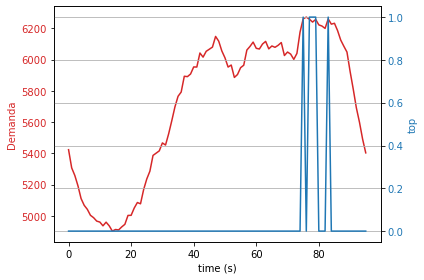

In [61]:
print("Antes")
print("Y_insample_df.shape", Y_insample_df_raw.shape)
print("Y_outsample_df.shape", Y_outsample_df_raw.shape)
print("\n\n")

#--------------------------------------------   One hot encode top 6 --------------------------------------------#
# Y_insample_df = Y_insample_df_raw.copy()
Y_outsample_df = Y_outsample_df_raw[:-1].copy()
Y_insample_df = get_top6(df=Y_insample_df_raw, variable='y')
# X_insample_df = get_top6(df=X_insample_df_raw, variable='ejecutado')
X_insample_df = X_insample_df_raw.copy()
# X_outsample_df = get_top6(df=X_outsample_df_raw[:-1], variable='ejecutado') # There is an extra hour

array([1., 1., 1., ..., 1., 1., 1.])

In [94]:
np.max(loss_weights)

10.0

In [62]:
Y_insample_df

,unique_id,ds,y
0,demanda_final,2017-10-07 00:00:00,0
1,demanda_final,2017-10-07 00:15:00,0
2,demanda_final,2017-10-07 00:30:00,0
3,demanda_final,2017-10-07 00:45:00,0
4,demanda_final,2017-10-07 01:00:00,0
...,...,...,...
101755,demanda_final,2020-08-31 22:45:00,0
101756,demanda_final,2020-08-31 23:00:00,0
101757,demanda_final,2020-08-31 23:15:00,0
101758,demanda_final,2020-08-31 23:30:00,0


In [63]:
X_insample_df

,ds,unique_id,ejecutado,DECIMAL_HOUR,DAY_OF_YEAR,DAY_OF_WEEK,IS_WEEKDAY,IS_HOLIDAY,L_1,L_2,L_3,L_4,L_5,L_6,L_7,PE_1,PD_1,PS_1,PE_7,PD_7,PS_7,PD_0,PS_0,P_1,P_2,P_3,P_4,P_5,P_6,P_7,AVG_1,AVG_2,AVG_3,AVG_4,AVG_5,AVG_6,AVG_7,MOV_7,MOV_14,DELTA_1,DELTA_7,PEAK_TIME_1,PEAK_TIME_2,PEAK_TIME_3,PEAK_TIME_4,PEAK_TIME_5,PEAK_TIME_6,PEAK_TIME_7,PE_PP1,PE_PP2,PE_PP3,PE_PP4,PE_PP5,PE_PP6,PE_PP7,PE_PP8,PE_PP9,PE_PP10,PE_PP11,PE_PP12,PE_PP13,PE_PP14,PE_PP15,PE_PP16,PE_PP17,PE_PP18,PE_PP19,PE_PP20,PE_PP21,PE_PP22,PE_PP23,PE_PP24,PE_PP25,PE_PP26,PE_PP27,PE_PP28,PE_PP29,PE_PP30,PE_PP31,PE_PP32,PE_PP33,PE_PP34,PE_PP35,PE_PP36,PE_PP37,PE_PP38,PE_PP39,PE_PP40,PE_PP41,PE_PP42,PE_PP43,PE_PP44,PE_PP45,PE_PP46,PE_PP47,PE_PP48,PD_PP1,PD_PP2,PD_PP3,PD_PP4,PD_PP5,PD_PP6,PD_PP7,PD_PP8,PD_PP9,PD_PP10,PD_PP11,PD_PP12,PD_PP13,PD_PP14,PD_PP15,PD_PP16,PD_PP17,PD_PP18,PD_PP19,PD_PP20,PD_PP21,PD_PP22,PD_PP23,PD_PP24,PD_PP25,PD_PP26,PD_PP27,PD_PP28,PD_PP29,PD_PP30,PD_PP31,PD_PP32,PD_PP33,PD_PP34,PD_PP35,PD_PP36,PD_PP37,PD_PP38,PD_PP39,PD_PP40,PD_PP41,PD_PP42,PD_PP43,PD_PP44,PD_PP45,PD_PP46,PD_PP47,PD_PP48,PS_PP1,PS_PP2,PS_PP3,PS_PP4,PS_PP5,PS_PP6,PS_PP7,PS_PP8,PS_PP9,PS_PP10,PS_PP11,PS_PP12,PS_PP13,PS_PP14,PS_PP15,PS_PP16,PS_PP17,PS_PP18,PS_PP19,PS_PP20,PS_PP21,PS_PP22,PS_PP23,PS_PP24,PS_PP25,PS_PP26,PS_PP27,PS_PP28,PS_PP29,PS_PP30,PS_PP31,PS_PP32,PS_PP33,PS_PP34,PS_PP35,PS_PP36,PS_PP37,PS_PP38,PS_PP39,PS_PP40,PS_PP41,PS_PP42,PS_PP43,PS_PP44,PS_PP45,PS_PP46,PS_PP47,PS_PP48,DELTA_PP1,DELTA_PP2,DELTA_PP3,DELTA_PP4,DELTA_PP5,DELTA_PP6,DELTA_PP7,DELTA_PP8,DELTA_PP9,DELTA_PP10,DELTA_PP11,DELTA_PP12,DELTA_PP13,DELTA_PP14,DELTA_PP15,DELTA_PP16,DELTA_PP17,DELTA_PP18,DELTA_PP19,DELTA_PP20,DELTA_PP21,DELTA_PP22,DELTA_PP23,DELTA_PP24,DELTA_PP25,DELTA_PP26,DELTA_PP27,DELTA_PP28,DELTA_PP29,DELTA_PP30,DELTA_PP31,DELTA_PP32,DELTA_PP33,DELTA_PP34,DELTA_PP35,DELTA_PP36,DELTA_PP37,DELTA_PP38,DELTA_PP39,DELTA_PP40,DELTA_PP41,DELTA_PP42,DELTA_PP43,DELTA_PP44,DELTA_PP45,DELTA_PP46,DELTA_PP47,DELTA_PP48,temp_Ancash,temp_Arequipa,temp_Cusco,temp_Ica,temp_Lima,feels_like_Ancash,feels_like_Arequipa,feels_like_Cusco,feels_like_Ica,feels_like_Lima,rain_1h_Ancash,rain_1h_Arequipa,rain_1h_Cusco,rain_1h_Ica,rain_1h_Lima,pressure_Ancash,pressure_Arequipa,pressure_Cusco,pressure_Ica,pressure_Lima,humidity_Ancash,humidity_Arequipa,humidity_Cusco,humidity_Ica,humidity_Lima,wind_speed_Ancash,wind_speed_Arequipa,wind_speed_Cusco,wind_speed_Ica,wind_speed_Lima,clouds_all_Ancash,clouds_all_Arequipa,clouds_all_Cusco,clouds_all_Ica,clouds_all_Lima,temperature_0,temperature_1,temperature_2,temperature_3,temperature_4,pressure_0,pressure_1,pressure_2,pressure_3,pressure_4,humidity_0,humidity_1,humidity_2,humidity_3,humidity_4,wind_speed_0,wind_speed_1,wind_speed_2,wind_speed_3,wind_speed_4,rain_0,rain_1,rain_2,rain_3,rain_4,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,2017-10-07 00:00:00,demanda_final,5522.52359,0.00,280,7,0,0,5427.81282,5444.23863,5382.13134,5297.62816,5003.93277,5469.80380,5543.54757,5401.05189,5567.13782,5416.46841,5533.78500,5495.96699,5435.83580,5559.55969,5447.38701,6285.68004,6063.81402,6274.26737,6186.15479,6153.28317,6017.21126,6227.70716,5812.529571,5683.086984,5659.550477,5552.333640,5455.458901,5137.682206,5641.027461,5563.095606,5595.209252,473.150469,586.679699,19.0,21.75,18.75,19.75,19.0,20.25,20.75,5705.92737,5778.30200,5959.79329,6127.81847,6179.83933,6226.70145,6226.43267,6240.99027,6227.01880,6271.91587,6252.88890,5948.89415,6013.53241,6113.22254,6050.63703,6186.22110,6217.96117,6229.67571,6174.85669,6099.79195,6047.35638,6089.84764,6113.87500,6205.50876,6296.94876,6194.11048,6156.32352,6164.34407,6041.92704,5999.30681,5910.66906,5721.48965,5648.94435,5581.98574,5458.88953,5342.26518,5210.87922,5194.31368,5117.02403,5015.20287,5011.75982,5025.32881,4917.43509,5017.27217,5066.98034,5104.04557,5

In [112]:
probs = np.ones(24*4)
probs[(17*4):(23*4)] = 100 #mc['peak_relative_importance']
weights_df = pd.DataFrame({'DECIMAL_HOUR':np.arange(0,24,0.25), 'prob':probs})
windows_prob_df = X_insample_df[['DECIMAL_HOUR']]
windows_prob_df['DECIMAL_HOUR'] = windows_prob_df['DECIMAL_HOUR'].apply(lambda x: (x) % 24) 
windows_prob_df = windows_prob_df.merge(weights_df, on='DECIMAL_HOUR', how='left')
loss_weights = windows_prob_df['prob'].values
loss_weights
# loss_weights = 1+Y_insample_df.y.values*100

print("Y_insample_df.shape", Y_insample_df.shape)
print("X_insample_df.shape", X_insample_df.shape)
print("Y_outsample_df.shape", Y_outsample_df.shape)
print("X_outsample_df.shape", X_outsample_df.shape)

#Y_insample_df['y'] = Y_insample_df['top']
#del Y_insample_df['top']

dataset = TimeSeriesDataset(Y_df=Y_insample_df,
                            S_df=None, X_df=X_insample_df,
                            ts_train_mask=ts_train_mask,
                            loss_weights=loss_weights,
                            f_cols=f_cols)

Y_insample_df.shape (101760, 3)
X_insample_df.shape (101760, 331)
Y_outsample_df.shape (2880, 3)
X_outsample_df.shape (2880, 331)
Processing dataframes ...
Creating ts tensor ...


In [113]:
train_loader = TimeSeriesLoaderFast(ts_dataset=dataset,
                                    model='nbeats',
                                    offset=0,
                                    window_sampling_limit=60*6*16, 
                                    input_size=3*16,
                                    output_size=16,
                                    idx_to_sample_freq=1,
                                    batch_size=256,
                                    shuffle=True,
                                    is_train_loader=True)

val_loader = TimeSeriesLoaderFast(ts_dataset=dataset,
                                  model='nbeats',
                                  offset=0,
                                  window_sampling_limit=60*6*16,
                                  input_size=3*16,
                                  output_size=16,
                                  idx_to_sample_freq=1,
                                  batch_size=256,
                                  shuffle=False,
                                  is_train_loader=False)

In [114]:
start = time.time()
dataloader = iter(train_loader)
batch = next(dataloader)
insample_y = batch['insample_y']
insample_x = batch['insample_x']
insample_mask = batch['insample_mask']
outsample_x = batch['outsample_x']
outsample_y = batch['outsample_y']
outsample_mask = batch['outsample_mask']
print("DataloaderGeneral batch time:", time.time()-start)
print("insample_y.shape", insample_y.shape)
print("insample_x.shape", insample_x.shape)
print("outsample_y.shape", outsample_y.shape)
print("outsample_x.shape", outsample_x.shape)

# print("t.max(insample_y)", t.max(insample_y))
#print("t.max(outsample_y)", t.max(outsample_y * outsample_mask))
outsample_mask
# outsample_y

DataloaderGeneral batch time: 0.04344606399536133
insample_y.shape torch.Size([256, 48])
insample_x.shape torch.Size([256, 328, 48])
outsample_y.shape torch.Size([256, 16])
outsample_x.shape torch.Size([256, 328, 16])


tensor([[  1.,   1.,   1.,  ...,   1.,   1., 100.],
        [  1.,   1.,   1.,  ...,   1.,   1.,   1.],
        [100., 100., 100.,  ...,   1.,   1.,   1.],
        ...,
        [  1.,   1.,   1.,  ..., 100., 100., 100.],
        [100., 100., 100.,  ..., 100., 100., 100.],
        [  1.,   1.,   1.,  ...,   1.,   1.,   1.]])

In [115]:
nbeatsx = Nbeats(input_size_multiplier=3,
                 output_size=16,
                 shared_weights=False,
                 stack_types=['identity'],
                 n_blocks=4*[1],
                 n_layers=4*[2],
                 n_hidden=4*[256],
                 n_harmonics=1,
                 n_polynomials=2,
                 x_s_n_hidden=0,
                 exogenous_n_channels=2,
                 f_cols=f_cols,
                 batch_normalization=False,
                 dropout_prob=0.1,
                 theta_with_exogenous=False,
                 learning_rate=0.001,
                 lr_decay=0.5,
                 n_lr_decay_steps=3,
                 weight_decay=0.0000001,
                 l1_lambda_x=0.0001,
                 n_iterations=1000,
                 early_stopping=100,
                 loss='BCE',
                 val_loss='TPR',
                 frequency=24,
                 random_seed=1,
                 seasonality='H')

nbeatsx.fit(train_ts_loader=train_loader, val_ts_loader=val_loader, verbose=True, eval_steps=1)

============================== Start fitting ==============================
Number of exogenous variables: 328
Number of static variables: 0 , with dim_hidden: 0
Number of iterations: 1000
Number of blocks: 1
Iteration: 1, Time: 0.182, Insample BCE: 150866.29688, Outsample TPR: 1.00000
Iteration: 2, Time: 0.766, Insample BCE: 130372.20312, Outsample TPR: 1.00000
Iteration: 3, Time: 1.376, Insample BCE: 99572.25000, Outsample TPR: 1.00000
Iteration: 4, Time: 1.945, Insample BCE: 84604.33594, Outsample TPR: 1.00000
Iteration: 5, Time: 2.511, Insample BCE: 67476.22656, Outsample TPR: 1.00000
Iteration: 6, Time: 3.071, Insample BCE: 57070.48828, Outsample TPR: 0.95417
Iteration: 7, Time: 3.648, Insample BCE: 37863.47656, Outsample TPR: 0.64097
Iteration: 8, Time: 4.293, Insample BCE: 23032.65039, Outsample TPR: 0.42639
Iteration: 9, Time: 4.859, Insample BCE: 11430.67383, Outsample TPR: 0.06875
Iteration: 10, Time: 5.427, Insample BCE: 13171.19336, Outsample TPR: 0.00000
Iteration: 11, Tim

In [ ]:
Y_insample_df_raw

In [8]:
X_insample_df

,ds,unique_id,ejecutado,DECIMAL_HOUR_x,DAY_OF_YEAR_x,DAY_OF_WEEK_x,IS_WEEKDAY_x,IS_HOLIDAY_x,L_1_x,L_2_x,L_3_x,L_4_x,L_5_x,L_6_x,L_7_x,PE_1_x,PD_1_x,PS_1_x,PE_7_x,PD_7_x,PS_7_x,PD_0_x,PS_0_x,P_1_x,P_2_x,P_3_x,P_4_x,P_5_x,P_6_x,P_7_x,AVG_1_x,AVG_2_x,AVG_3_x,AVG_4_x,AVG_5_x,AVG_6_x,AVG_7_x,MOV_7_x,MOV_14_x,DELTA_1_x,DELTA_7_x,PEAK_TIME_1_x,PEAK_TIME_2_x,PEAK_TIME_3_x,PEAK_TIME_4_x,PEAK_TIME_5_x,PEAK_TIME_6_x,PEAK_TIME_7_x,PE_PP1_x,PE_PP2_x,PE_PP3_x,PE_PP4_x,PE_PP5_x,PE_PP6_x,PE_PP7_x,PE_PP8_x,PE_PP9_x,PE_PP10_x,PE_PP11_x,PE_PP12_x,PE_PP13_x,PE_PP14_x,PE_PP15_x,PE_PP16_x,PE_PP17_x,PE_PP18_x,PE_PP19_x,PE_PP20_x,PE_PP21_x,PE_PP22_x,PE_PP23_x,PE_PP24_x,PE_PP25_x,PE_PP26_x,PE_PP27_x,PE_PP28_x,PE_PP29_x,PE_PP30_x,PE_PP31_x,PE_PP32_x,PE_PP33_x,PE_PP34_x,PE_PP35_x,PE_PP36_x,PE_PP37_x,PE_PP38_x,PE_PP39_x,PE_PP40_x,PE_PP41_x,PE_PP42_x,PE_PP43_x,PE_PP44_x,PE_PP45_x,PE_PP46_x,PE_PP47_x,PE_PP48_x,PD_PP1_x,PD_PP2_x,PD_PP3_x,PD_PP4_x,PD_PP5_x,PD_PP6_x,PD_PP7_x,PD_PP8_x,PD_PP9_x,PD_PP10_x,PD_PP11_x,PD_PP12_x,PD_PP13_x,PD_PP14_x,PD_PP15_x,PD_PP16_x,PD_PP17_x,PD_PP18_x,PD_PP19_x,PD_PP20_x,PD_PP21_x,PD_PP22_x,PD_PP23_x,PD_PP24_x,PD_PP25_x,PD_PP26_x,PD_PP27_x,PD_PP28_x,PD_PP29_x,PD_PP30_x,PD_PP31_x,PD_PP32_x,PD_PP33_x,PD_PP34_x,PD_PP35_x,PD_PP36_x,PD_PP37_x,PD_PP38_x,PD_PP39_x,PD_PP40_x,PD_PP41_x,PD_PP42_x,PD_PP43_x,PD_PP44_x,PD_PP45_x,PD_PP46_x,PD_PP47_x,PD_PP48_x,PS_PP1_x,PS_PP2_x,PS_PP3_x,PS_PP4_x,PS_PP5_x,PS_PP6_x,PS_PP7_x,PS_PP8_x,PS_PP9_x,PS_PP10_x,PS_PP11_x,PS_PP12_x,PS_PP13_x,PS_PP14_x,PS_PP15_x,PS_PP16_x,PS_PP17_x,PS_PP18_x,PS_PP19_x,PS_PP20_x,PS_PP21_x,PS_PP22_x,PS_PP23_x,PS_PP24_x,PS_PP25_x,PS_PP26_x,PS_PP27_x,PS_PP28_x,PS_PP29_x,PS_PP30_x,PS_PP31_x,PS_PP32_x,PS_PP33_x,PS_PP34_x,PS_PP35_x,PS_PP36_x,PS_PP37_x,PS_PP38_x,PS_PP39_x,PS_PP40_x,PS_PP41_x,PS_PP42_x,PS_PP43_x,PS_PP44_x,PS_PP45_x,PS_PP46_x,PS_PP47_x,PS_PP48_x,DELTA_PP1_x,DELTA_PP2_x,DELTA_PP3_x,DELTA_PP4_x,DELTA_PP5_x,DELTA_PP6_x,DELTA_PP7_x,DELTA_PP8_x,DELTA_PP9_x,DELTA_PP10_x,DELTA_PP11_x,DELTA_PP12_x,DELTA_PP13_x,DELTA_PP14_x,DELTA_PP15_x,DELTA_PP16_x,DELTA_PP17_x,DELTA_PP18_x,DELTA_PP19_x,DELTA_PP20_x,DELTA_PP21_x,DELTA_PP22_x,DELTA_PP23_x,DELTA_PP24_x,DELTA_PP25_x,DELTA_PP26_x,DELTA_PP27_x,DELTA_PP28_x,DELTA_PP29_x,DELTA_PP30_x,DELTA_PP31_x,DELTA_PP32_x,DELTA_PP33_x,DELTA_PP34_x,DELTA_PP35_x,DELTA_PP36_x,DELTA_PP37_x,DELTA_PP38_x,DELTA_PP39_x,DELTA_PP40_x,DELTA_PP41_x,DELTA_PP42_x,DELTA_PP43_x,DELTA_PP44_x,DELTA_PP45_x,DELTA_PP46_x,DELTA_PP47_x,DELTA_PP48_x,temp_Ancash_x,temp_Arequipa_x,temp_Cusco_x,temp_Ica_x,temp_Lima_x,feels_like_Ancash_x,feels_like_Arequipa_x,feels_like_Cusco_x,feels_like_Ica_x,feels_like_Lima_x,rain_1h_Ancash_x,rain_1h_Arequipa_x,rain_1h_Cusco_x,rain_1h_Ica_x,rain_1h_Lima_x,pressure_Ancash_x,pressure_Arequipa_x,pressure_Cusco_x,pressure_Ica_x,pressure_Lima_x,humidity_Ancash_x,humidity_Arequipa_x,humidity_Cusco_x,humidity_Ica_x,humidity_Lima_x,wind_speed_Ancash_x,wind_speed_Arequipa_x,wind_speed_Cusco_x,wind_speed_Ica_x,wind_speed_Lima_x,clouds_all_Ancash_x,clouds_all_Arequipa_x,clouds_all_Cusco_x,clouds_all_Ica_x,clouds_all_Lima_x,temperature_0_x,temperature_1_x,temperature_2_x,temperature_3_x,temperature_4_x,pressure_0_x,pressure_1_x,pressure_2_x,pressure_3_x,pressure_4_x,humidity_0_x,humidity_1_x,humidity_2_x,humidity_3_x,humidity_4_x,wind_speed_0_x,wind_speed_1_x,wind_speed_2_x,wind_speed_3_x,wind_speed_4_x,rain_0_x,rain_1_x,rain_2_x,rain_3_x,rain_4_x,hour_0_x,hour_1_x,hour_2_x,hour_3_x,hour_4_x,hour_5_x,hour_6_x,hour_7_x,hour_8_x,hour_9_x,hour_10_x,hour_11_x,hour_12_x,hour_13_x,hour_14_x,hour_15_x,hour_16_x,hour_17_x,hour_18_x,hour_19_x,hour_20_x,hour_21_x,hour_22_x,hour_23_x,day_0_x,day_1_x,day_2_x,day_3_x,day_4_x,day_5_x,day_6_x,ds_day,DECIMAL_HOUR_y,DAY_OF_YEAR_y,DAY_OF_WEEK_y,IS_WEEKDAY_y,IS_HOLIDAY_y,L_1_y,L_2_y,L_3_y,L_4_y,L_5_y,L_6_y,L_7_y,PE_1_y,PD_1_y,PS_1_y,PE_7_y,PD_7_y,PS_7_y,PD_0_y,PS_0_y,P_1_y,P_2_y,P_3_y,P_4_y,P_5_y,P_6_y,P_7_y,AVG_1_y,AVG_2_y,AVG_3_y,AVG_4_y,AVG_5_y,AVG_6_y,AVG_7_y,MOV_7_y,MOV_14_y,DELTA_1_y,DELTA_7_y,PEAK_TIME_1_y,PE